In [6]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

#Hyperparameters
learning_rate  = 0.0003
gamma           = 0.9
lmbda           = 0.9
eps_clip        = 0.2
K_epoch         = 10
rollout_len    = 3
buffer_size    = 10
minibatch_size = 32

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        self.fc1   = nn.Linear(1,128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.fc_v = nn.Linear(128,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.optimization_step = 0

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        mu = torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                td_target = r + gamma * self.v(s_prime) * done_mask
                delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

        
    def train_net(self):
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch

                    mu, std = self.pi(s, softmax_dim=1)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target)

                    self.optimizer.zero_grad()
                    loss.mean().backward()
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                    self.optimizer.step()
                    self.optimization_step += 1
        

In [7]:
from utils import * 
from algorithms import *
from agents import *
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces

class GymEnv(gym.Env):
    def __init__(self, metaData, buyers, sellers, log):
        self.gameData = metaData[0:8]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = self.gameData
        self.disclosure, self.buyers, self.sellers = metaData[8:]
        self.log = log
        self.rnd = 0
        self.period = 0
        self.Step = 0
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float32)
        self.numStates = len(generateState(self.buyers[0]))
        self.observation_space = spaces.Box(-1,9,(self.numStates,),dtype=np.float32)
        startRounds(self.gameData, self.log, self.buyers, self.sellers, self.rnd)
    
    def reset(self, seed = None):
        startPeriods(self.buyers, self.sellers)
        generateState(self.buyers[0])
        return self.buyers[0].state, {}

    def step(self, action):
        startSteps(self.buyers, self.sellers)
        bids, asks = collectOffers(self.buyers, self.sellers)
        min = buyers[0].stepTokenValue*0.01
        max = buyers[0].stepTokenValue*1.5
        bids[0] = min * (1-(action[0]+1)/2) + (action[0]+1)/2 * max
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
        bprofit, sprofit = 0, 0
        if price > 0:
            self.buyers[currentBidIdx].transact(price)
            self.sellers[currentAskIdx].transact(price)
            bprofit = self.buyers[currentBidIdx].stepProfits
            sprofit = self.sellers[currentAskIdx].stepProfits
        self.log.addStep([self.rnd, self.period, self.Step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(self.buyers, self.sellers, log.disclose())
        reward = 0.0
        if price > 0 and currentBidIdx == 0:
            reward = np.nan_to_num(bprofit,nan=0)
        updateStates(self.buyers, self.sellers)
        newState = self.buyers[0].state
        done = self.buyers[0].done
        updatePolicy(self.buyers, self.sellers)
        endSteps(self.buyers, self.sellers)
        self.Step += 1
        if done:
            endPeriods(self.buyers, self.sellers)
            self.period += 1
            self.Step = 0
        return newState, reward, done, False, {}

import warnings 
warnings.filterwarnings('ignore')
import torch as th
th.autograd.set_detect_anomaly(True)
numRounds, numPeriods, numSteps = 1, 10000, 9
numBuyers, numSellers, numTokens = 3, 6, 4
gameTypes, seed = '1111', 42
disclosure = []
#disclosure = ['currentBid','currentAsk','price']
depth = 0
# ZeroIntelligence, TruthTeller

gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, depth = depth),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
]
sellers = [
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
]
log = Log(gameData, disclosure)
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed, disclosure, buyers, sellers]
env = GymEnv(metaData, buyers, sellers, log)
print(log.roundData.iloc[0].buyerValues)
print(log.roundData.iloc[0].sellerCosts)
print(buyers[0].state)

ModuleNotFoundError: No module named 'utils'

In [5]:
model = PPO()
score = 0.0
print_interval = 20
rollout = []
num_states = 1

for n_epi in range(10000):
    s, _ = env.reset()
    done = False
    count = 0
    a_list = []
    while count < 200 and not done:
        for t in range(rollout_len):
            mu, std = model.pi(torch.from_numpy(np.array(s)).float())
            dist = Normal(mu, std)
            a = dist.sample()
            a_list.append(a.item())
            log_prob = dist.log_prob(a)
            s_prime, r, done, truncated, info = env.step([a.item()])
            rollout.append((s, a, r, s_prime, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []
            s = s_prime
            score += r
            count += 1
        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}, optmization step: {}, {:.3f}, {:.3f}, {:.3f}, {:.3f}".format(n_epi,
                                                                                          score/print_interval,
                                                                                          model.optimization_step,
                                                                                          mu.item(), std.item(), 
                                                                                          np.mean(a_list), np.std(a_list)
                                                                                         ))
        score = 0.0

NameError: name 'env' is not defined

In [6]:
pd.option_context('display.float_format', '{:0.20f}'.format)
log.stepData.tail(15)

NameError: name 'pd' is not defined

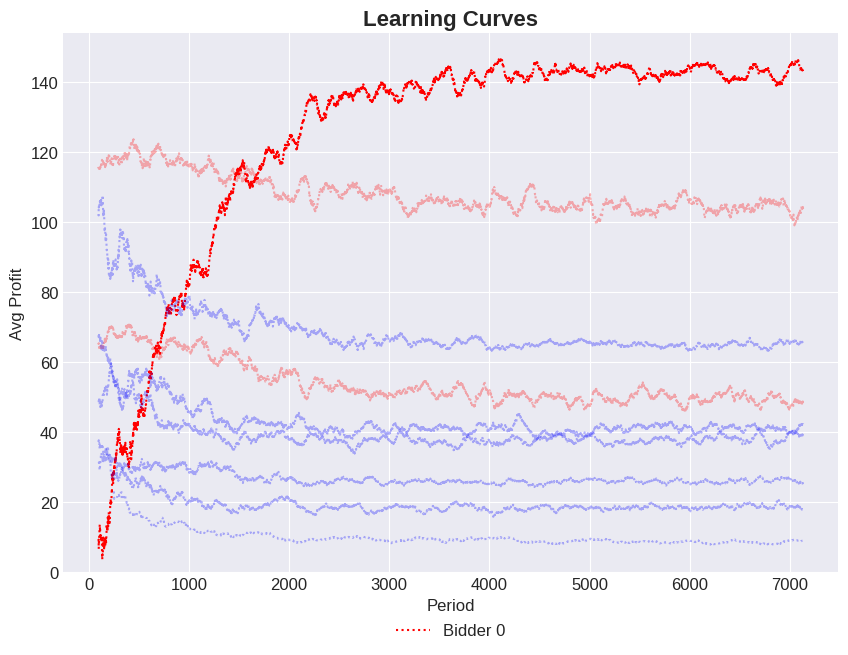

In [34]:
log.graphLearning(trackBuyersIdx = [0], trackSellersIdx = [], rolling_window=100, type = 'period')

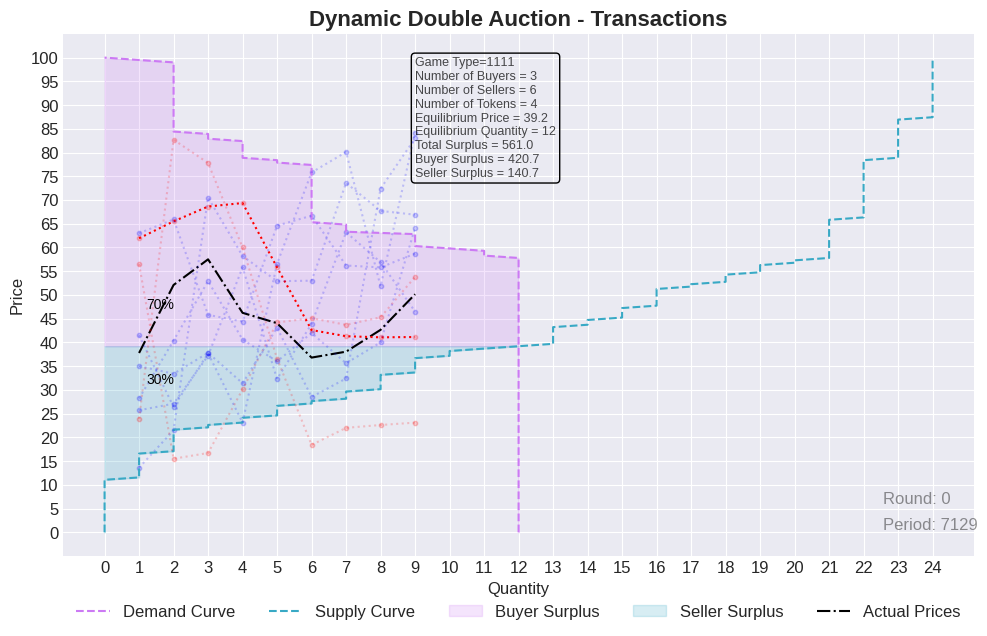

In [38]:
log.graphSales(0, 7129, trackBuyersIdx=[0], trackSellersIdx=[])

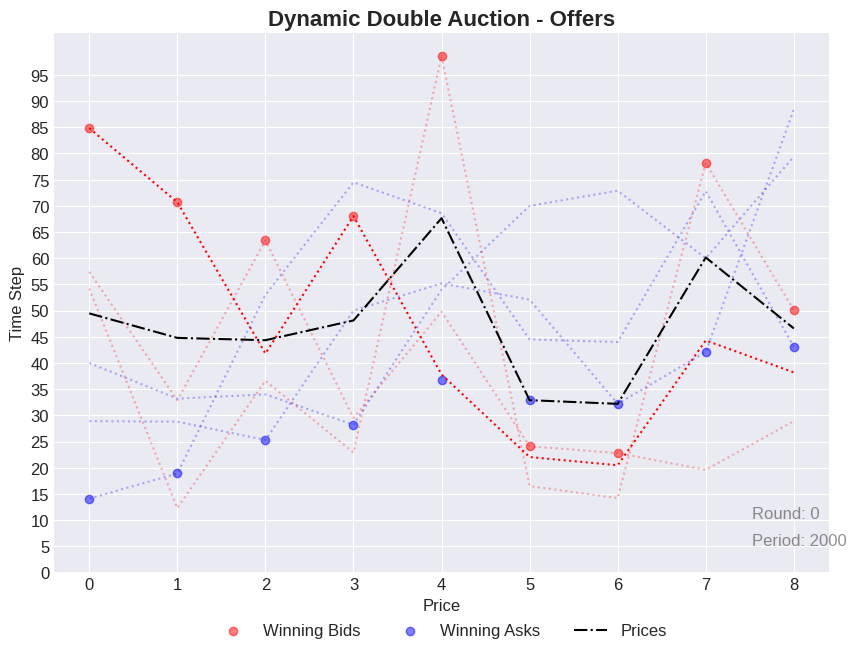

In [42]:
log.graphOffers(0, 2000, trackBuyersIdx=[0], trackSellersIdx=[])

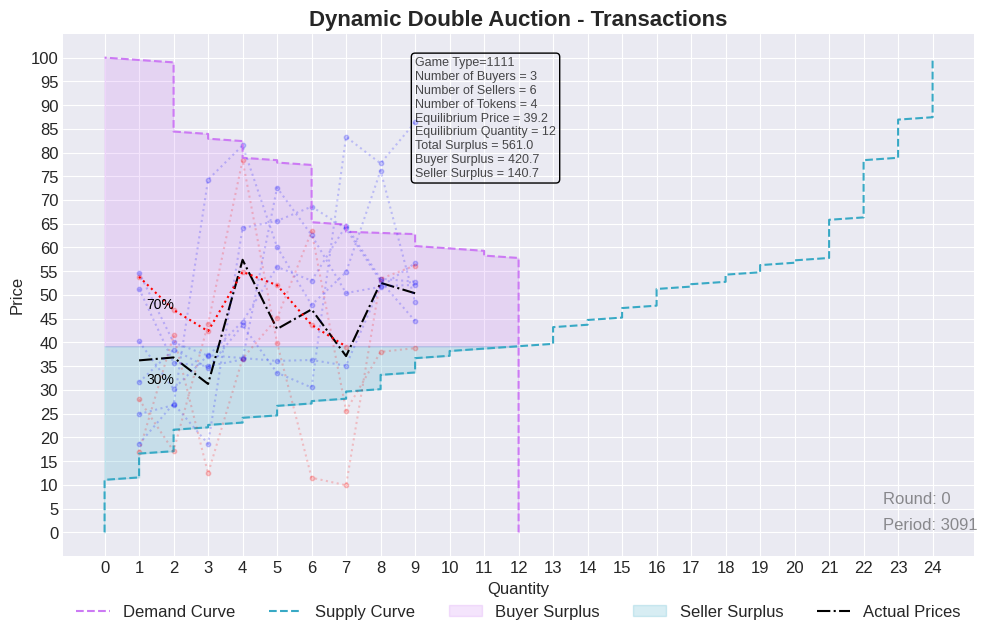

In [15]:
log.graphSales(0, 3091, trackBuyersIdx=[0], trackSellersIdx=[])

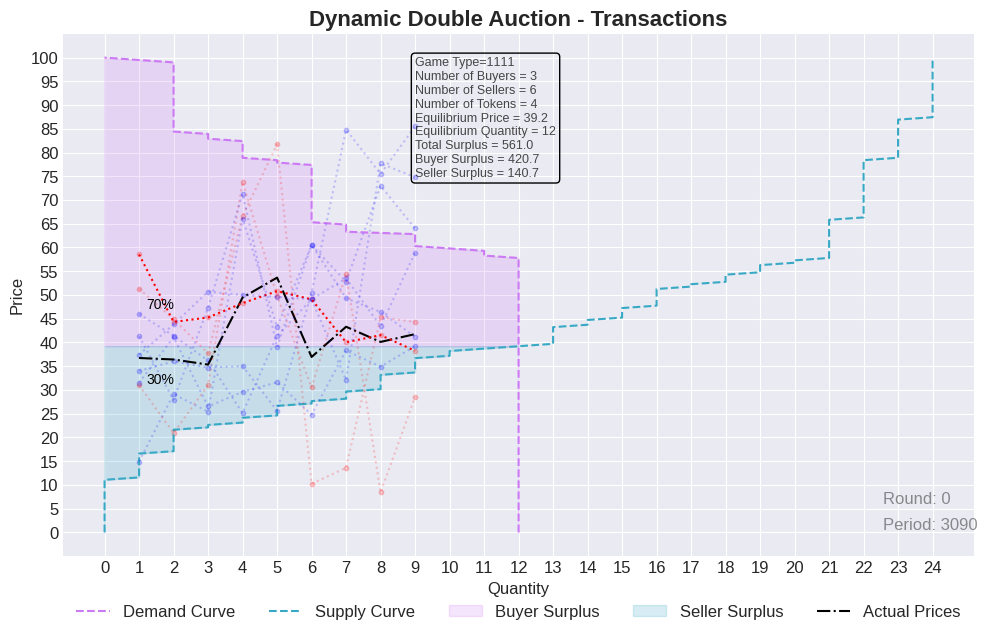

In [16]:
log.graphSales(0, 3090, trackBuyersIdx=[0], trackSellersIdx=[])

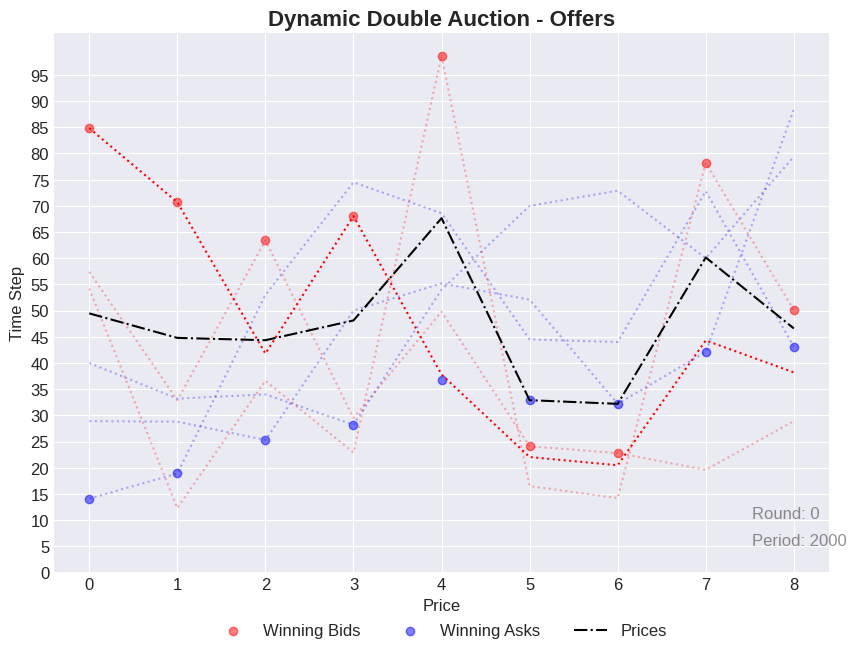

In [44]:
log.graphOffers(0, 2000, trackBuyersIdx=[0], trackSellersIdx=[])

In [45]:

class Log:
    def __init__(self, gameData,disclosure):
        self.gameData = gameData
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.stepData = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','currentBid','currentBidIdx','currentAsk',
                                             'currentAskIdx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.roundData = pd.DataFrame(columns=['rnd', 'buyerValues', 'sellerCosts', 'demand', 'supply', 'prices', 'peq', 'qeq', 
                                              'buyerReservationPrices', 'sellerReservationPrices', 'buyerSurplus', 'sellerSurplus', 
                                              'totalSurplus', 'buyerSurplusFrac', 'sellerSurplusFrac'])
        self.disclosure = disclosure
        
    def addStep(self, stepData):
        self.stepData.loc[len(self.stepData.index)] = stepData

    def addRound(self, roundData):
        self.roundData.loc[len(self.roundData.index)] = roundData
    
    def disclose(self):
        return self.stepData[self.disclosure].iloc[-1]
        
    def getPeriod(self, rnd, period):
        return self.stepData[(self.stepData.rnd==rnd) & (self.stepData.period==period)]
        
    def getPeriodActivity(self, rnd, period):
        periodData = self.getPeriod(rnd, period)
        periodBids = list(periodData.bids)
        periodAsks = list(periodData.asks)
        periodPrices = list(periodData.price)
        periodSales = np.cumsum(np.where(periodData.price > 0,1,0))
        return np.array(periodBids), np.array(periodAsks), np.array(periodPrices), np.array(periodSales)

    def getRound(self, rnd):
        return self.roundData[(self.roundData.rnd==rnd)]

    def getRoundList(self, rnd):
        return self.getRound(rnd).values.tolist()[0][1:]


    def graphSales(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        colors = customGraphSettings()
        fig, ax = graphMarket(*self.gameData, *self.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='black', linestyle='dashdot', label='Actual Prices')
        
        for j in range(self.numBuyers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodBids[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackBuyersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'red')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'red', alpha = 0.2)
                
        for j in range(self.numSellers):
            y = [periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0]
            x = [periodAsks[i][j] for i in range(self.numSteps) if periodPrices[i] > 0]
            if j in trackSellersIdx:
                plt.plot(y, x, linestyle='dotted', color = 'blue')
            else:
                plt.plot(y, x, linestyle='dotted', color = 'blue', alpha = 0.2)
                
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter([periodSales[i]] * len(periodBids[i]), periodBids[i], s=10, alpha=0.2, c='red')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.2, c='blue')
                
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        ax.set_title('Dynamic Double Auction - Transactions', fontsize=16, fontweight='bold')
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()
    

    def graphOffers(self, rnd, period, trackBuyersIdx = [], trackSellersIdx = []):
        periodBids, periodAsks, periodPrices, periodSales = self.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        notTrackBuyers = [i for i in range(self.numBuyers) if i not in trackBuyersIdx]
        notTrackSellers = [i for i in range(self.numBuyers) if i not in trackSellersIdx]
        ax.plot(periodBids[:,notTrackBuyers], c='red', linestyle='dash', alpha = 0.3)
        ax.plot(periodBids[:,trackBuyersIdx], c='red', linestyle='dash', alpha = 1.0)
        #ax.scatter(range(self.numSteps), np.max(periodBids, axis = 1), c='red', label='Winning Bids', alpha = 0.5)
        ax.plot(periodAsks[:,notTrackSellers], c='blue', linestyle='dash', alpha = 0.3)
        ax.plot(periodAsks[:,trackSellersIdx], c='blue', linestyle='dash', alpha = 1.0)
        #ax.scatter(range(self.numSteps), np.min(periodAsks, axis = 1), c='blue', label='Winning Asks', alpha = 0.5)
        #ax.plot(periodBids, c='red', linestyle='dotted', label='Bids')
        #ax.plot(periodAsks, c='blue', linestyle='dotted', label='Asks')
        ax.plot(range(self.numSteps), periodPrices, c='black', label='Prices', linestyle='dashdot')
        ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Dynamic Double Auction - Offers', fontsize=16, fontweight='bold')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.xlabel('Price')
        plt.ylabel('Time Step')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        ax.set_yticks(np.arange(0, 100, 5))
        ax.set_xticks(np.arange(0, len(periodSales), 1))
        plt.text(0.90, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        plt.text(0.90, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        plt.show()


    def graphLearning(self, trackBuyersIdx = [], trackSellersIdx = [], rolling_window = 1, type = 'period'):
        df = self.stepData
        fig, ax = plt.subplots()
        colors = customGraphSettings()
        for j in range(self.numBuyers):
            rolling_mean = df[df.currentBidIdx == j][[type, 'bprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackBuyersIdx:
                ax.plot(rolling_mean, color = 'red', alpha = 1.0, linestyle = 'dotted', label = f'Bidder {j}')
            else:
                ax.plot(rolling_mean, color = 'red', alpha = 0.3, linestyle = 'dotted')
                
        for j in range(self.numSellers):
            rolling_mean = df[df.currentAskIdx == j][[type, 'sprofit']].groupby([type]).sum().rolling(rolling_window).mean()
            if j in trackSellersIdx:
                ax.plot(rolling_mean, color = 'blue', alpha = 1.0, linestyle = 'dotted', label = f'Asker {j}')
            else:
                ax.plot(rolling_mean, color = 'blue', alpha = 0.3, linestyle = 'dotted')
        
        ax.set_title('Learning Curves', fontsize=16, fontweight='bold')
        plt.xlabel('Period')
        plt.ylabel('Avg Profit')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position('bottom')
        #ax.set_yticks(np.arange(0, 100, 5))
        #ax.set_xticks(np.arange(0, 100, 20))
        #ax.text(0.80, 0.10, f'Round: {rnd}', transform=plt.gca().transAxes, alpha=0.5)
        #ax.text(0.80, 0.05, f'Period: {period}', transform=plt.gca().transAxes, alpha=0.5)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.ylim(ymin=0)
        plt.show()